# PCA

In [ ]:
import numpy as np
import sklearn
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.datasets import fashion_mnist
import seaborn as sns
import os
import gzip
import sys

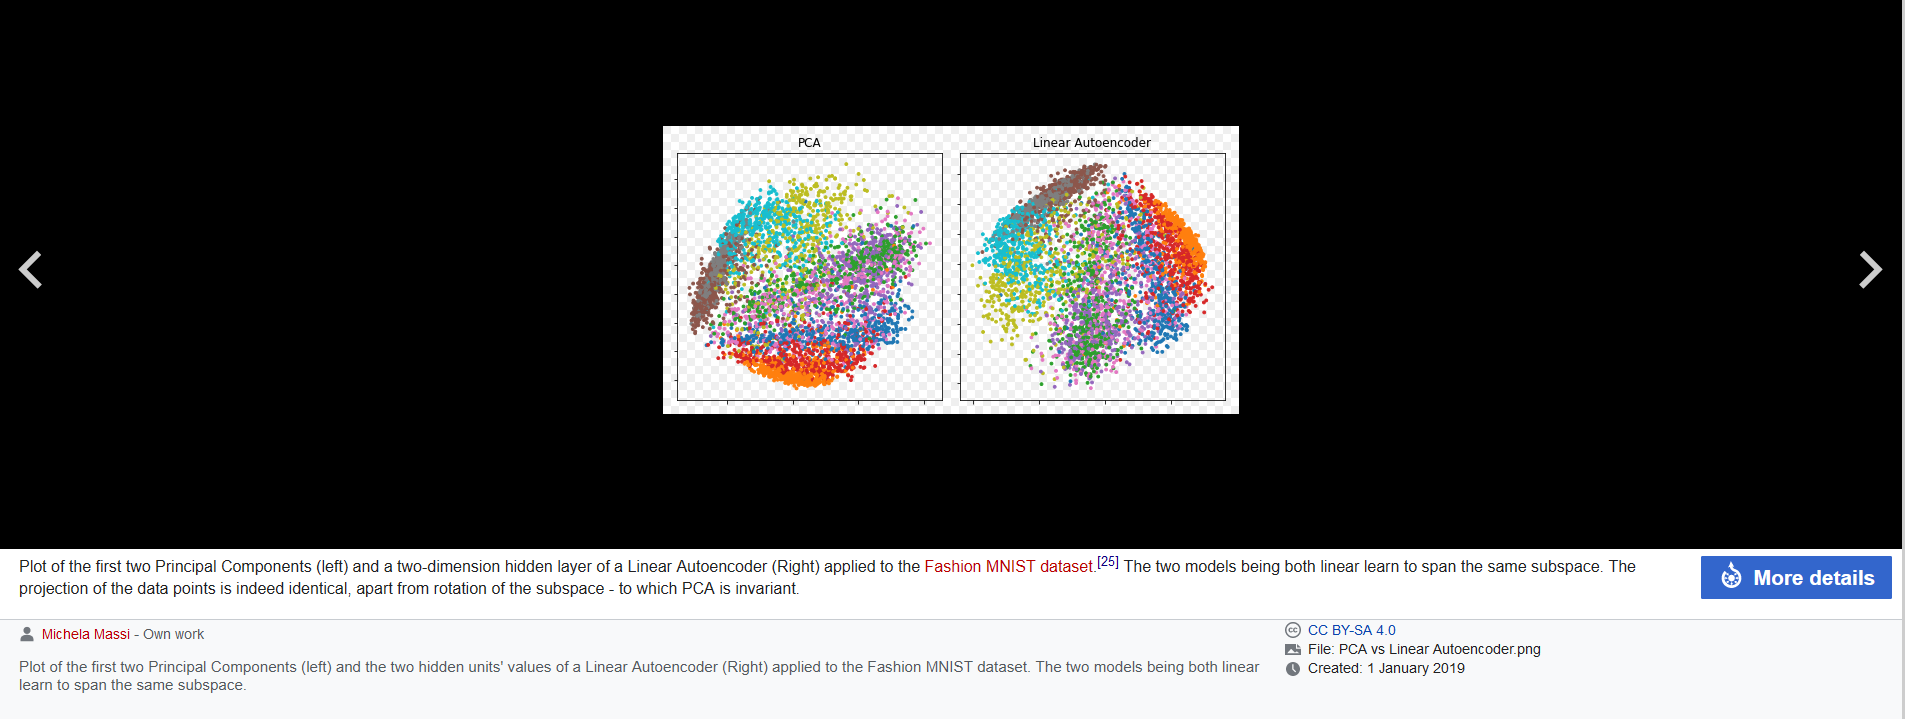

In [ ]:
# The number of components for pca
N_COMP =  100 #@param {type:"integer"}

In [ ]:
#Load data:
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
#Design matrix
print('Design matrix size: {}'.format(X_train.shape))

Design matrix size: (60000, 28, 28)


In [ ]:
# select only 10000 entries
X = X_train[:10000].reshape(10000, 28*28)
y = y_train[:10000]
print('Design matrix size: {}'.format(X.shape))

Design matrix size: (10000, 784)


(array([ 942., 1027., 1016., 1019.,  974.,  989., 1021., 1022.,  990.,
        1000.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

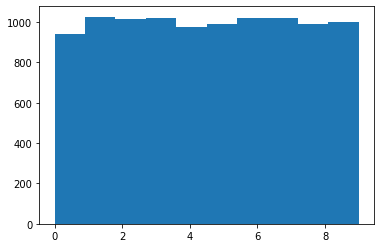

In [ ]:
# Each class is equally distributed
plt.hist(y, bins=10)

In [ ]:
#@title 
scaler = MinMaxScaler() #@param ["StandardScaler()", "MinMaxScaler()"] {type:"raw"}
#Normalize features:
X_norm = scaler.fit_transform(X)

In [ ]:
#Apply PCA:
pca = PCA(n_components=N_COMP)
X_norm_r = pca.fit(X_norm).transform(X_norm)

Text(0.5, 1.0, 'Component-wise and Cumulative Explained Variance')

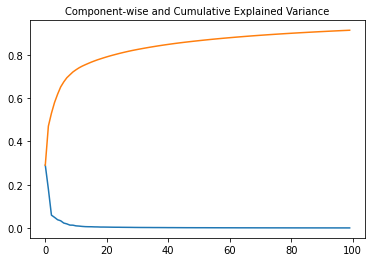

In [ ]:
#Plot Component-wise and Cumulative Explained Variance:
plt.subplot(1, 1, 1)
plt.plot(range(N_COMP), pca.explained_variance_ratio_)
plt.plot(range(N_COMP), np.cumsum(pca.explained_variance_ratio_))
plt.title("Component-wise and Cumulative Explained Variance", fontsize=10)

In [ ]:
SAMPLE_INDEX = 1 #@param {type:"integer"}


In [ ]:
#Invert the PCA to obtain the image with the new components:
inv = pca.inverse_transform(X_norm_r[SAMPLE_INDEX, :])
inv = scaler.inverse_transform(inv.reshape(1, -1)) #Unnormalize

In [ ]:
# first and second component shows 19.90816038%, 12.3440578% variance
pca.explained_variance_ 

array([19.90816038, 12.3440578 ,  4.08476887,  3.38992731,  2.63359359,
        2.30695522,  1.58484872,  1.32275233,  0.93530702,  0.90874507,
        0.69233472,  0.62360634,  0.51991806,  0.44841116,  0.4206539 ,
        0.4118544 ,  0.37067912,  0.35583739,  0.31561592,  0.31384498,
        0.29923304,  0.28435846,  0.2668705 ,  0.25671447,  0.2542121 ,
        0.23751597,  0.22886915,  0.22020005,  0.21188034,  0.19669939,
        0.18940927,  0.18121974,  0.17766711,  0.17156949,  0.16977009,
        0.16029515,  0.15733764,  0.15434118,  0.14819626,  0.14438488,
        0.13662464,  0.13589368,  0.13338621,  0.12585178,  0.12322918,
        0.1178054 ,  0.11333616,  0.11301708,  0.11036222,  0.10592795,
        0.10428579,  0.10397924,  0.10233156,  0.09884756,  0.09776726,
        0.09377837,  0.09252665,  0.09000111,  0.08744861,  0.0864115 ,
        0.08521554,  0.08337964,  0.08207534,  0.0788071 ,  0.07871057,
        0.07691714,  0.07613194,  0.07477351,  0.07291865,  0.07

In [ ]:
# Compute PCA to get the last components (in order of decreasing variance):
# Not sure how to do this in sklearn

X_norm = X_norm.T #Transpose the design matrix to match the formulas

S = X_norm @ X_norm.T #Covariance matrix
eigvals, eigvecs = np.linalg.eig(S) # compute eigenvalues and eigenvectors
order = np.argsort(eigvals) #sort eigenvalues in ascending order (add [::-1] to get descenging order)
B = eigvecs[:, order[:N_COMP]] #Take the last N_COMP eigenvectors as new basis

C = B.T @ X_norm #Code: projection of X in the subspace spanned by the columns of B

X_rec = B @ C #revert the tranformation to project the code back in the original space

X_rec = X_rec.T #Bring back the dimensions to the original convention
X_rec = scaler.inverse_transform(X_rec) #Unnormalize

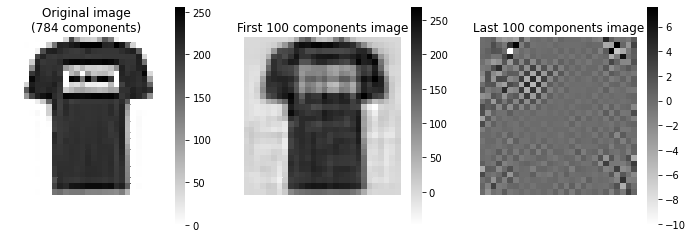

In [ ]:
#Plot images:
fig, axarr = plt.subplots(1, 3, figsize=(12, 4))
sns.heatmap(X[SAMPLE_INDEX, :].reshape(28, 28), cmap='gray_r', ax=axarr[0])
sns.heatmap(inv.reshape(28, 28), cmap='gray_r', ax=axarr[1])
sns.heatmap(X_rec[SAMPLE_INDEX, :].reshape(28, 28), cmap='gray_r', ax=axarr[2])
axarr[0].set_title("Original image\n({} components)".format(X.shape[1]), fontsize=12)
axarr[1].set_title("First {} components image".format(N_COMP), fontsize=12)
axarr[2].set_title("Last {} components image".format(N_COMP), fontsize=12)
axarr[0].set_aspect('equal')
axarr[1].set_aspect('equal')
axarr[2].set_aspect('equal')
axarr[0].axis('off')
axarr[1].axis('off')
axarr[2].axis('off')

plt.show()

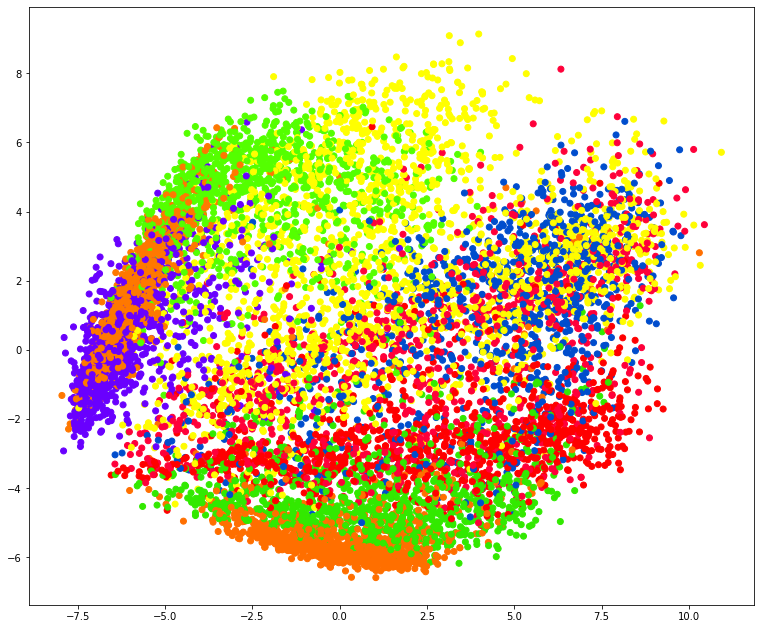

In [ ]:
plt.figure(figsize=[13, 11])
plt.scatter(X_norm_r[:, 0], X_norm_r[:, 1], c=y, cmap='prism')
plt.savefig('pca_scatter.png', dpi=200, bbox_inches='tight')

# Autoencoder

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import math
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

### How simple is MNIST!! 
We are able to compress 28x28=786 size image into 3x3=9 image

In [ ]:
encoder_size = 196 #@param ["196", "64", "9"] {type:"raw"}


### Creating an AutoEncoder

In [ ]:
# encoder_input = keras.Input(shape=(28,28,1), name="img")
# x = keras.layers.Flatten()(encoder_input)
# encoder_output = keras.layers.Dense(encoder_size, activation="relu")(x)

# encoder = keras.Model(encoder_input, encoder_output, name="encoder")
# decoder_input = keras.layers.Dense(784, activation="relu")(encoder_output)

# decoder_output = keras.layers.Reshape((28, 28, 1))(decoder_input)

# opt = keras.optimizers.Adam(lr=0.001, decay = 1e-6)

# autoencoder =  keras.Model(encoder_input, decoder_output, name="autoencoder")
# autoencoder.summary()

### Creating a Linear AutoEncoder with hidden size 2
i.e. We are compressing a 28x28 image in 2x1 pixel

In [ ]:
encoder_input = keras.Input(shape=(28,28,1), name="img")
x = keras.layers.Flatten()(encoder_input)
encoder_output = keras.layers.Dense(2, activation="linear")(x)

encoder = keras.Model(encoder_input, encoder_output, name="encoder")
decoder_input = keras.layers.Dense(784, activation="linear")(encoder_output)

decoder_output = keras.layers.Reshape((28, 28, 1))(decoder_input)

opt = keras.optimizers.Adam(lr=0.001, decay = 1e-6)

autoencoder =  keras.Model(encoder_input, decoder_output, name="autoencoder")
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 img (InputLayer)            [(None, 28, 28, 1)]       0         
                                                                 
 flatten_24 (Flatten)        (None, 784)               0         
                                                                 
 dense_73 (Dense)            (None, 2)                 1570      
                                                                 
 dense_74 (Dense)            (None, 784)               2352      
                                                                 
 reshape_23 (Reshape)        (None, 28, 28, 1)         0         
                                                                 
Total params: 3,922
Trainable params: 3,922
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
autoencoder.compile(opt, loss="mse")

In [ ]:
X.shape

(10000, 784)

In [ ]:
# The shape of X is (10000, 784) but our network needs (something. 28, 28) form
autoencoder.fit(X.reshape(-1, 28, 28), X.reshape(-1, 28, 28), epochs=3, batch_size=32)

Epoch 1/3
313/313 [==============================] - 2s 4ms/step - loss: 5080.7871
Epoch 2/3
313/313 [==============================] - 1s 4ms/step - loss: 3197.2510
Epoch 3/3
313/313 [==============================] - 1s 4ms/step - loss: 3192.0947


In [ ]:
example = encoder.predict([X_test[0].reshape(-1, 28, 28, 1)])[0]

In [ ]:
example

array([ 189.32263, 1274.3473 ], dtype=float32)

In [ ]:
example.shape

(2,)

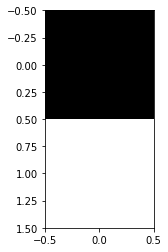

In [ ]:
# plt.imshow(example.reshape(int(math.sqrt(encoder_size)), int(math.sqrt(encoder_size))), cmap="gray")
plt.imshow(example.reshape(2, 1), cmap="gray")

### Orignal test image

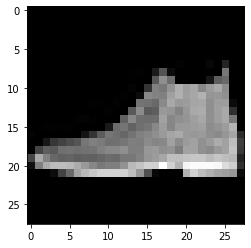

In [ ]:
plt.imshow(X_test[0], cmap="gray")

### Encoded test image

In [ ]:
ae_out = autoencoder.predict([X_test[0].reshape(-1, 28, 28, 1)])[0]

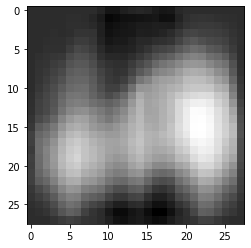

In [ ]:
plt.imshow(ae_out.reshape(28,28), cmap="gray")

In [ ]:
posttrain_encodings = encoder(X_test).numpy()

In [ ]:
posttrain_encodings.shape

(10000, 2)

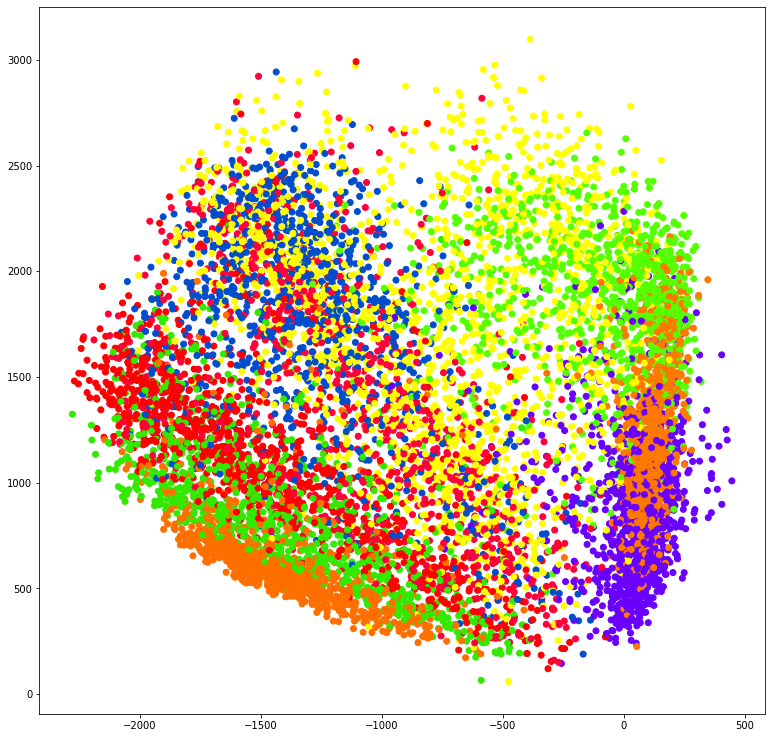

In [ ]:
plt.figure(figsize=[13, 13])
plt.scatter(posttrain_encodings[:, 0],
                posttrain_encodings[:, 1], c=y_test, cmap="prism")

plt.savefig('linearautoencoder_scatter.png', dpi=200, bbox_inches='tight')

# Comparing both the plots

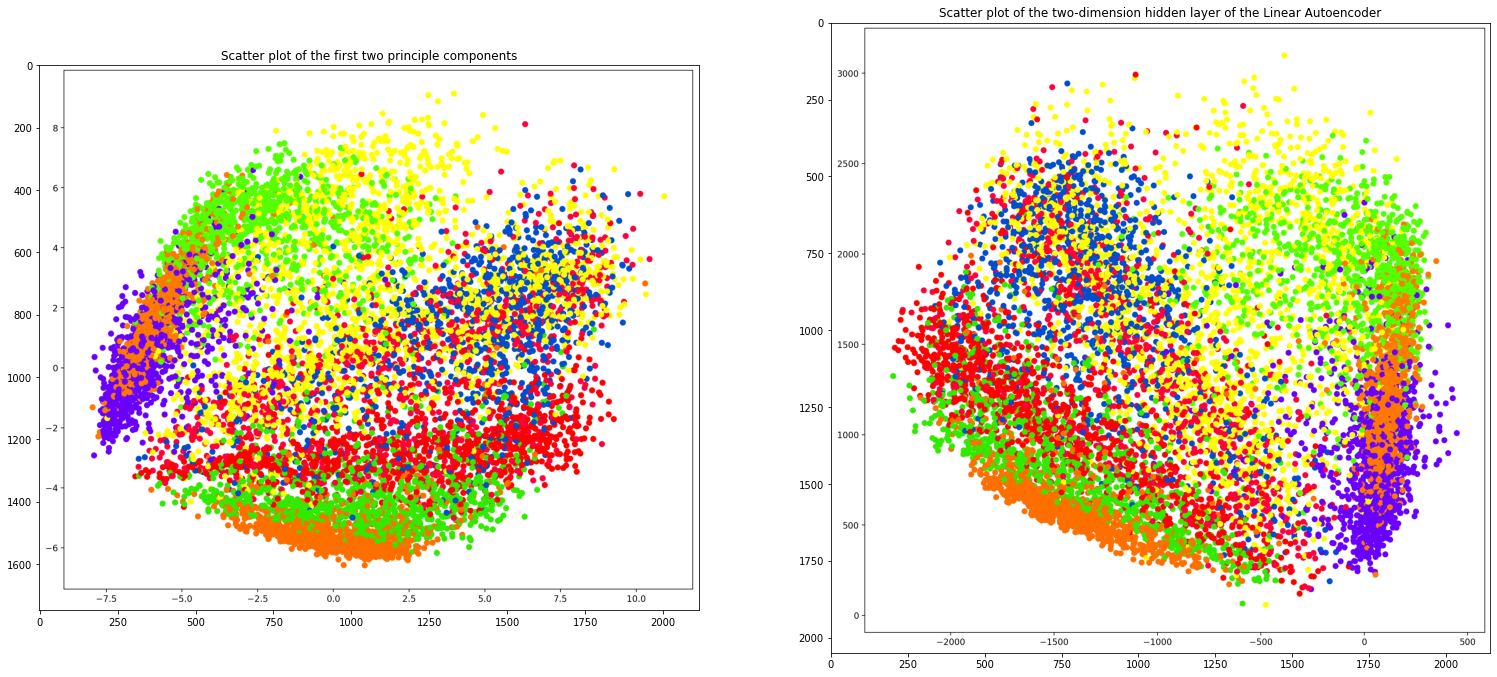

In [ ]:
import matplotlib.image as mpimg
plt.figure(figsize=(26, 12))
plt.axis('off')

plt.subplot(1, 2, 1)
plt.title('Scatter plot of the first two principle components')
plt.imshow(mpimg.imread('pca_scatter.png'))

plt.subplot(1, 2, 2)
plt.title('Scatter plot of the two-dimension hidden layer of the Linear Autoencoder')
plt.imshow(mpimg.imread('linearautoencoder_scatter.png'))